## This notebook calculates the climate risk metrics sourced from Pacific Institute. The metrics include:

* delta percent change in slr tract vulnerablility between 2000 and 2100
* number of exposed buildings, with SLR mask applied
* $ value of replacing buildings & contents
* delta change in number of fire stations vulnerable to sea level rise between baseline and 1.4m rise conditions
* delta change in number of police stations vulnerable to sea level rise between baseline and 1.4m rise conditions
* delta change in number of schools vulnerable to sea level rise between baseline and 1.4m rise conditions
* delta change in number of hospitals vulnerable to sea level rise between baseline and 1.4m rise conditions
* number of wastewater treatment plants vulnerable to sea level rise under 1.4m rise conditions

In [21]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd
import numpy as np

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.calculate_index import add_census_tracts

In [3]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/climate_risk/sea_level_rise/exposure/projections/pacific_institute/'
output_folder = '../data_metric_calc'

pull_gpkg_from_directory(bucket_name, aws_dir)
pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False)

Saved GeoPackage as 'climate_pacific_institute_slr_exposure_fire_stations_2000.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_fire_stations_2100.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_hospitals_2000.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_hospitals_2100.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_police_stations_2000.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_police_stations_2100.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_schools_2000.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_schools_2100.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_superfund.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_wastewater_treatment.gpkg' locally
Saved GeoPackage as 'climate_pacific_institute_slr_exposure_wastewater_treatment_2000.gpkg' l

In [4]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '1_pull_data/climate_risk/sea_level_rise/exposure/projections/pacific_institute/'
output_folder = '../data_metric_calc'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False)

Saved DataFrame as '../data_metric_calc/building_count.csv'
Saved DataFrame as '../data_metric_calc/total_value_building_contents.csv'


### Metric 1: delta in % tract vulnerable to sea level rise between baseline and 1.4m rise conditions
    * the data is at the census block level, so there are multiple entries for census tracts
    * group by census tract and take the average percentage per tract

In [5]:
census_vulnerable_slr_tracts = pd.read_csv('climate_pacific_institute_slr_exposure_census_vulnerability.csv')
os.remove('climate_pacific_institute_slr_exposure_census_vulnerability.csv')
census_vulnerable_slr_tracts

,CensusBlock,CountyFIPS,BlkArea_m2,Perc_2000,Perc_2100,CensusTract
0,60014017001002,1,7.400145e+04,0.013629,0.103142,6001401700
1,60014017001009,1,1.661440e+04,0.162421,0.818744,6001401700
2,60014017001011,1,2.034830e+04,0.033993,0.145896,6001401700
3,60014017002024,1,2.437019e+04,0.007894,0.054463,6001401700
4,60014017002025,1,1.384990e+04,0.218054,0.323897,6001401700
...,...,...,...,...,...,...
9415,61110073001115,111,6.546174e+04,0.008397,0.037215,6111007300
9416,61110073001120,111,2.331707e+04,0.010518,0.024219,6111007300
9417,61110073001121,111,3.143619e+06,0.000482,0.001053,6111007300
9418,61110073001124,111,2.357066e+04,0.006471,0.271358,6111007300


In [6]:
# select relevant columns
slr_tracts_columns = census_vulnerable_slr_tracts[['CensusTract', 'Perc_2000', 'Perc_2100']]
slr_tracts_columns = slr_tracts_columns.rename(columns={'CensusTract':'tract','Perc_2000':'percent_2000', 'Perc_2100':'percent_2100'})
slr_tracts_columns

,tract,percent_2000,percent_2100
0,6001401700,0.013629,0.103142
1,6001401700,0.162421,0.818744
2,6001401700,0.033993,0.145896
3,6001401700,0.007894,0.054463
4,6001401700,0.218054,0.323897
...,...,...,...
9415,6111007300,0.008397,0.037215
9416,6111007300,0.010518,0.024219
9417,6111007300,0.000482,0.001053
9418,6111007300,0.006471,0.271358


In [7]:
# this data is at the census block scale so there are multiple repeat census tracts
# census tracts are grouped together and have their percentage columns averaged
slr_tracts_grouped = slr_tracts_columns.groupby('tract')[['percent_2000', 'percent_2100']].mean().reset_index()
slr_tracts_grouped

,tract,percent_2000,percent_2100
0,6001401700,0.173551,0.332988
1,6001401900,0.130183,0.389499
2,6001403200,0.010183,0.186697
3,6001403300,0.302783,0.452502
4,6001403400,0.205320,0.411437
...,...,...,...
626,6111004600,0.911470,0.959438
627,6111004702,0.522970,0.805990
628,6111004704,0.235746,0.650934
629,6111005600,0.361981,0.665406


In [8]:
# looking at how many unique tracts there are
unique = slr_tracts_grouped.tract.unique()
print(len(unique))

631


In [10]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)

# adjust the columns and entries within so merging with slr data is easier
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)
ca_tract_county = ca_tract_county.drop(columns={'field_1', 'countyfp'})

# Remove leading zeros from the 'tract' column
ca_tract_county['tract'] = ca_tract_county['tract'].str.lstrip('0')

ca_tract_county

,tract,county
0,6085504321,santa clara
1,6085504410,santa clara
2,6085507003,santa clara
3,6085507004,santa clara
4,6085502204,santa clara
...,...,...
9124,6059001303,orange
9125,6059001304,orange
9126,6059001401,orange
9127,6013367200,contra costa


In [11]:
# make sure columns are the same datatype
ca_tract_county['tract'] = ca_tract_county['tract'].astype(str)
slr_tracts_grouped['tract'] = slr_tracts_grouped['tract'].astype(str)

# merge slr data with census tract data
merged_slr_tracts = pd.merge(ca_tract_county, slr_tracts_grouped, on='tract', how='left')
merged_slr_tracts

,tract,county,percent_2000,percent_2100
0,6085504321,santa clara,NaN,NaN
1,6085504410,santa clara,NaN,NaN
2,6085507003,santa clara,NaN,NaN
3,6085507004,santa clara,NaN,NaN
4,6085502204,santa clara,NaN,NaN
...,...,...,...,...
9124,6059001303,orange,NaN,NaN
9125,6059001304,orange,NaN,NaN
9126,6059001401,orange,NaN,NaN
9127,6013367200,contra costa,NaN,NaN


In [12]:
metric_slr_tracts = merged_slr_tracts

# calculate delta percent change between 2000 and 2100 columns
metric_slr_tracts['delta_percentage_change'] = (merged_slr_tracts['percent_2100'] - merged_slr_tracts['percent_2000']) * 100
metric_slr_tracts

,tract,county,percent_2000,percent_2100,delta_percentage_change
0,6085504321,santa clara,NaN,NaN,NaN
1,6085504410,santa clara,NaN,NaN,NaN
2,6085507003,santa clara,NaN,NaN,NaN
3,6085507004,santa clara,NaN,NaN,NaN
4,6085502204,santa clara,NaN,NaN,NaN
...,...,...,...,...,...
9124,6059001303,orange,NaN,NaN,NaN
9125,6059001304,orange,NaN,NaN,NaN
9126,6059001401,orange,NaN,NaN,NaN
9127,6013367200,contra costa,NaN,NaN,NaN


In [13]:
# Find the index of the maximum value in the delta column
max_index = metric_slr_tracts['delta_percentage_change'].idxmax()

# Retrieve the row corresponding to the maximum value
max_row = metric_slr_tracts.loc[max_index]

# Display the entire row
print(max_row)

tract                      6001440305
county                        alameda
percent_2000                 0.227321
percent_2100                 0.961435
delta_percentage_change      73.41142
Name: 5470, dtype: object


In [12]:
# save as csv
metric_slr_tracts.to_csv('climate_slr_vulnerable_metric.csv', index=False)

## Metric 2: # of exposed buildings
Note: The count of exposed buildings to SLR includes in-land counties/tracts. After investigation, this appears to come directly from the FEMA HAZUS model. Therefore, we intentionally apply a mask of in-land counties to only focus on coastal counties, in line with our other SLR metrics. 

More info on the SLR mask found here: `climate_slr_mask_layer.ipynb`

In [14]:
building_data = pd.read_csv('building_count.csv')

In [15]:
columns_to_sum = [
'Residential',
'Commercial',
'Industrial',
'Agricultural',
'Religious',
'Government',
'Education'
]

# Fill NaNs with 0 before summing, if you want to treat NaNs as zeroes
building_data[columns_to_sum] = building_data[columns_to_sum].fillna(0)

# Recalculate the total
building_data['total'] = building_data[columns_to_sum].sum(axis=1)
building_data

,OBJECTID,CensusBlock,CountyFIPS,Tract,Residential,Commercial,Industrial,Agricultural,Religious,Government,Education,total
0,1,60371349021011,37,6037134902,0,0,0,0,0,0,0,0
1,2,60376008012003,37,6037600801,26,2,0,0,0,0,0,28
2,3,60590423122006,59,6059042312,0,1,0,0,1,0,1,3
3,4,60250125001066,25,6025012500,4,0,0,0,0,0,0,4
4,5,60376022008004,37,6037602200,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
526236,526237,60373014004012,37,6037301400,16,1,0,0,0,0,0,17
526237,526238,61030001001677,103,6103000100,0,0,0,0,0,0,0,0
526238,526239,60590218251007,59,6059021825,49,1,1,0,0,0,0,51
526239,526240,60390004001104,39,6039000400,0,0,0,0,0,0,0,0


In [16]:
building_columns = building_data[['Tract', 'CountyFIPS', 'total']]
building_columns

,Tract,CountyFIPS,total
0,6037134902,37,0
1,6037600801,37,28
2,6059042312,59,3
3,6025012500,25,4
4,6037602200,37,0
...,...,...,...
526236,6037301400,37,17
526237,6103000100,103,0
526238,6059021825,59,51
526239,6039000400,39,0


In [17]:
grouped_building_data = building_columns.groupby('Tract')['total'].sum().reset_index(name='building_count')
grouped_building_data = grouped_building_data.rename(columns={'Tract':'tract'})
grouped_building_data

,tract,building_count
0,6001400100,1315
1,6001400200,775
2,6001400300,1941
3,6001400400,1328
4,6001400500,1057
...,...,...
7044,6115040800,1732
7045,6115040901,1127
7046,6115040902,1762
7047,6115041000,2944


In [23]:
# make sure columns are the same datatype
grouped_building_data['tract'] = grouped_building_data['tract'].astype(str)

# merge slr data with census tract data
merged_vulnerable_buildings = pd.merge(ca_tract_county, grouped_building_data, on='tract', how='left')
merged_vulnerable_buildings['GEOID'] = '0' + merged_vulnerable_buildings['tract']
merged_vulnerable_buildings

,tract,county,building_count,GEOID
0,6085504321,santa clara,1426.0,06085504321
1,6085504410,santa clara,1121.0,06085504410
2,6085507003,santa clara,NaN,06085507003
3,6085507004,santa clara,NaN,06085507004
4,6085502204,santa clara,NaN,06085502204
...,...,...,...,...
9124,6059001303,orange,1279.0,06059001303
9125,6059001304,orange,919.0,06059001304
9126,6059001401,orange,1433.0,06059001401
9127,6013367200,contra costa,1074.0,06013367200


In [26]:
## apply the mask (utils/slr_mask_layer.csv')
slr_coast_counties = ['001', '013', '015', '023', '037', '041', '045', '053', '055', '059', '067', '073', '075', '077', '079', '081', '083', '085', '087', '095', '097', '111', '113']

In [27]:
gdf = add_census_tracts(merged_vulnerable_buildings)
gdf.head(5)

,tract,county,building_count,GEOID,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,6085504321,santa clara,1426.0,06085504321,06,085,504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,6085504410,santa clara,1121.0,06085504410,06,085,504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,6085507003,santa clara,NaN,06085507003,06,085,507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02458 37.2..."
3,6085507004,santa clara,NaN,06085507004,06,085,507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,6085502204,santa clara,NaN,06085502204,06,085,502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


In [28]:
# set any county not in slr_coast_counties to nan
gdf.loc[~gdf['COUNTYFP'].isin(slr_coast_counties), 'building_count'] = np.nan

In [29]:
# check that it did reset
gdf.loc[~gdf['COUNTYFP'].isin(slr_coast_counties)]

,tract,county,building_count,GEOID,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
121,6029001301,kern,NaN,06029001301,06,029,001301,13.01,Census Tract 13.01,G5020,S,1027441,0,+35.3834279,-118.9825024,"POLYGON ((-118.98873 35.37909, -118.98871 35.3..."
122,6029003135,kern,NaN,06029003135,06,029,003135,31.35,Census Tract 31.35,G5020,S,1385084,0,+35.3035181,-119.1234186,"POLYGON ((-119.12813 35.29815, -119.12813 35.2..."
123,6029001107,kern,NaN,06029001107,06,029,001107,11.07,Census Tract 11.07,G5020,S,550527,0,+35.3743302,-118.9580398,"POLYGON ((-118.96748 35.37401, -118.96748 35.3..."
124,6029003212,kern,NaN,06029003212,06,029,003212,32.12,Census Tract 32.12,G5020,S,4333818,190217,+35.3382047,-119.1372019,"POLYGON ((-119.14564 35.32935, -119.14561 35.3..."
125,6029005509,kern,NaN,06029005509,06,029,005509,55.09,Census Tract 55.09,G5020,S,120534842,5245,+35.5725952,-117.6939426,"POLYGON ((-117.80064 35.65142, -117.79946 35.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,6065040616,riverside,NaN,06065040616,06,065,040616,406.16,Census Tract 406.16,G5020,S,8477461,192259,+33.9420499,-117.5775081,"POLYGON ((-117.59997 33.92761, -117.59995 33.9..."
9116,6065040813,riverside,NaN,06065040813,06,065,040813,408.13,Census Tract 408.13,G5020,S,12837511,0,+33.9165340,-117.5336103,"POLYGON ((-117.56324 33.89583, -117.56321 33.8..."
9117,6065040814,riverside,NaN,06065040814,06,065,040814,408.14,Census Tract 408.14,G5020,S,1088362,0,+33.8973552,-117.5175804,"POLYGON ((-117.5284 33.89746, -117.52826 33.89..."
9118,6065041910,riverside,NaN,06065041910,06,065,041910,419.10,Census Tract 419.10,G5020,S,11145322,2955,+33.7892199,-117.4949771,"POLYGON ((-117.51796 33.82099, -117.51729 33.8..."


In [30]:
gdf.loc[~gdf['COUNTYFP'].isin(slr_coast_counties)]['building_count'].unique() # confirmed applied!

array([nan])

<Axes: >

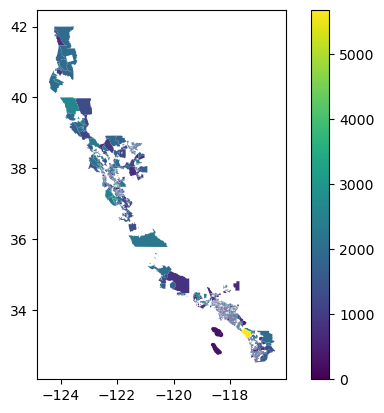

In [31]:
gdf.plot('building_count', legend=True)

In [33]:
# clean up before export
gdf_to_save = gdf[['tract', 'GEOID', 'county', 'building_count']]

In [34]:
gdf_to_save.to_csv('climate_slr_vulnerable_buildings_metric.csv', index=False)

## Metric #3: value of replacing buildings & contents from potential SLR

In [19]:
building_cost_data = pd.read_csv('total_value_building_contents.csv')
building_cost_data

,OBJECTID,CensusBlock,CountyFIPS,Tract,Total,Residential,Commercial,Industrial,Agriculture,Religion,Government,Education
0,2346539,60014001001000,1,6001400100,29805,26837,1518,190,0,1260,0,0
1,2279529,60014001001001,1,6001400100,0,0,0,0,0,0,0,0
2,2408728,60014001001002,1,6001400100,0,0,0,0,0,0,0,0
3,2152840,60014001001003,1,6001400100,0,0,0,0,0,0,0,0
4,2219421,60014001001004,1,6001400100,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
266303,2397779,61110085003073,111,6111008500,1547,1547,0,0,0,0,0,0
266304,2468943,61110085003074,111,6111008500,10864,630,968,0,0,0,9266,0
266305,2245822,61110085003075,111,6111008500,3665,315,0,0,0,3350,0,0
266306,2379306,61110085003076,111,6111008500,3326,0,1074,0,0,0,2252,0


In [20]:
building_cost_columns = building_cost_data[['Tract', 'CountyFIPS', 'Total']]


In [21]:
# to check totals calculated in the cell below are accurate
check_tract = building_cost_columns[building_cost_columns['Tract'] == 6001400100]
total_sum = check_tract['Total'].sum()
print(total_sum)

650084


In [22]:
grouped_building_cost = building_cost_columns.groupby('Tract')['Total'].sum().reset_index(name='building_content_cost')
grouped_building_cost = grouped_building_cost.rename(columns={'Tract':'tract'})
grouped_building_cost

,tract,building_content_cost
0,6001400100,650084
1,6001400200,434115
2,6001400300,922941
3,6001400400,594158
4,6001400500,398157
...,...,...
5109,6111008305,413169
5110,6111008306,475903
5111,6111008401,589055
5112,6111008402,591579


In [23]:
# make sure columns are the same datatype
grouped_building_cost['tract'] = grouped_building_cost['tract'].astype(str)

# merge slr data with census tract data
merged_building_content_cost = pd.merge(ca_tract_county, grouped_building_cost, on='tract', how='left')
merged_building_content_cost

,tract,county,building_content_cost
0,6085504321,santa clara,590746.0
1,6085504410,santa clara,463564.0
2,6085507003,santa clara,NaN
3,6085507004,santa clara,NaN
4,6085502204,santa clara,NaN
...,...,...,...
9124,6059001303,orange,583032.0
9125,6059001304,orange,363856.0
9126,6059001401,orange,588570.0
9127,6013367200,contra costa,470589.0


In [24]:
# how many non nan entries do we have in our final metric for building and content cost
print(len(merged_building_content_cost.building_content_cost.unique()))

3813


In [25]:
merged_building_content_cost.to_csv('climate_slr_buildings_contents_cost_metric.csv', index=False)

## Now for metrics that do not have both baseline and 1.4m rise conditions
* number of wastewater treatment plants vulnerable to sea level rise under 1.4m rise conditions
* number of superfund sites vulnerable to flooding following 1.4m sea level rise

In [26]:
# first calling all shapefiles in
slr_fire_stations_2000 = gpd.read_file('climate_pacific_institute_slr_exposure_fire_stations_2000.gpkg')
slr_fire_stations_2100 = gpd.read_file('climate_pacific_institute_slr_exposure_fire_stations_2100.gpkg')
slr_hospitals_2000 = gpd.read_file('climate_pacific_institute_slr_exposure_hospitals_2000.gpkg')
slr_hospitals_2100 = gpd.read_file('climate_pacific_institute_slr_exposure_hospitals_2100.gpkg')
slr_police_stations_2000 = gpd.read_file('climate_pacific_institute_slr_exposure_police_stations_2000.gpkg')
slr_police_stations_2100 = gpd.read_file('climate_pacific_institute_slr_exposure_police_stations_2100.gpkg')
slr_schools_2000 = gpd.read_file('climate_pacific_institute_slr_exposure_schools_2000.gpkg')
slr_schools_2100 = gpd.read_file('climate_pacific_institute_slr_exposure_schools_2100.gpkg')
slr_wastewater_2100 = gpd.read_file('climate_pacific_institute_slr_exposure_wastewater_treatment_2100.gpkg')


In [27]:
county_slr_wastewater_2100 = slr_wastewater_2100[['USCB_COUNTYFP', 'USCB_NAME']]
county_slr_wastewater_2100.head()

,USCB_COUNTYFP,USCB_NAME
0,023,4
1,095,2521.02
2,055,2010.05
3,095,2507.01
4,041,1262


In [28]:
county_slr_wastewater_2100.groupby('USCB_COUNTYFP').count().reset_index()

,USCB_COUNTYFP,USCB_NAME
0,001,4
1,013,2
2,023,1
3,041,3
4,053,1
5,055,1
6,059,1
7,075,1
8,081,6
9,083,1


In [29]:
county_slr_wastewater_2100.USCB_COUNTYFP.unique()

array(['023', '095', '055', '041', '013', '075', '085', '081', '001',
       '087', '053', '083', '059'], dtype=object)

## Looking at shared columns between all of the shape files
* all share countyfp columns which is what we want

In [30]:
# List of GeoDataFrames
gdfs = [slr_fire_stations_2000, slr_fire_stations_2100, slr_hospitals_2000, slr_hospitals_2100,
        slr_police_stations_2000, slr_police_stations_2100, slr_schools_2000, slr_schools_2100,
        slr_wastewater_2100]

# Get the set of columns for each GeoDataFrame
column_sets = [set(gdf.columns) for gdf in gdfs]

# Find the intersection of all columns (shared columns)
shared_columns = set.intersection(*column_sets)

# Find the unique columns for each GeoDataFrame
unique_columns = [columns - shared_columns for columns in column_sets]

# Print the shared columns
print("Shared columns among all GeoDataFrames:", shared_columns)

# Print the unique columns for each GeoDataFrame
for idx, unique in enumerate(unique_columns):
    print(f"Unique columns in GeoDataFrame {idx+1}: {unique}")

Shared columns among all GeoDataFrames: {'USCB_ALAND', 'USCB_STATEFP', 'USCB_NAME', 'USCB_AWATER', 'geometry', 'USCB_FUNCSTAT', 'USCB_INTPTLAT', 'USCB_GEOID', 'USCB_NAMELSAD', 'USCB_INTPTLON', 'USCB_TRACTCE', 'USCB_MTFCC', 'USCB_COUNTYFP'}
Unique columns in GeoDataFrame 1: {'Address', 'Name', 'Statea', 'City', 'Zipcode'}
Unique columns in GeoDataFrame 2: {'Address', 'fld2100', 'Name', 'Statea', 'fld2000', 'City', 'Zipcode'}
Unique columns in GeoDataFrame 3: {'FACILITY', 'TYPE', 'ADDRESS_1', 'ZIP_CODE', 'LIC_BEDS', 'STATE', 'CATEGORY', 'COUNTY', 'CITY'}
Unique columns in GeoDataFrame 4: {'FACILITY', 'TYPE', 'ADDRESS_1', 'ZIP_CODE', 'LIC_BEDS', 'STATE', 'CATEGORY', 'COUNTY', 'CITY'}
Unique columns in GeoDataFrame 5: {'Address', 'EfClass', 'fld2100', 'Tract', 'Name', 'Statea', 'fld2000', 'PoliceStat', 'City', 'Zipcode'}
Unique columns in GeoDataFrame 6: {'Address', 'fld_2100', 'Name', 'fld_2000', 'Statea', 'City', 'Zipcode'}
Unique columns in GeoDataFrame 7: {'ADDRESS', 'ZIPCODE', 'LATITU

In [31]:
# all geodataframes share a common county fp column, so we have a function to count number
# of rows for a specified county fp number
# this will help fact check our new dfs that contain county counts per metric
def count_entries_by_county_fp(df, county_fp_number):
    """
    Returns the count of entries in the 'USCB_COUNTYFP' column that match the given county_fp_number.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    county_fp_number (str or int): The county FP number to match.

    Returns:
    int: The count of matching entries.
    """
    return df['USCB_COUNTYFP'].astype(str).eq(str(county_fp_number)).sum()

In [32]:
slr_wastewater_count = county_slr_wastewater_2100.groupby('USCB_COUNTYFP').size().reset_index(name='count')

In [33]:
# Rename the count column
slr_wastewater_count = slr_wastewater_count.rename(columns={'USCB_COUNTYFP':'countyfp', 'count': 'wastewater_count'})

slr_wastewater_metric = slr_wastewater_count
slr_wastewater_metric

,countyfp,wastewater_count
0,001,4
1,013,2
2,023,1
3,041,3
4,053,1
5,055,1
6,059,1
7,075,1
8,081,6
9,083,1


In [34]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1', 'geometry'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)

ca_tract_county

C:\Users\jesse\AppData\Local\Temp\ipykernel_18172\3785741718.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)


,tract,countyfp,county
0,06085504321,085,santa clara
1,06085504410,085,santa clara
2,06085507003,085,santa clara
3,06085507004,085,santa clara
4,06085502204,085,santa clara
...,...,...,...
9124,06059001303,059,orange
9125,06059001304,059,orange
9126,06059001401,059,orange
9127,06013367200,013,contra costa


In [35]:
merged_slr_wastewater_metric = pd.merge(ca_tract_county, slr_wastewater_metric, on='countyfp', how='left')
merged_slr_wastewater_metric

,tract,countyfp,county,wastewater_count
0,06085504321,085,santa clara,3.0
1,06085504410,085,santa clara,3.0
2,06085507003,085,santa clara,3.0
3,06085507004,085,santa clara,3.0
4,06085502204,085,santa clara,3.0
...,...,...,...,...
9124,06059001303,059,orange,1.0
9125,06059001304,059,orange,1.0
9126,06059001401,059,orange,1.0
9127,06013367200,013,contra costa,2.0


In [36]:
merged_slr_wastewater_metric.to_csv('climate_slr_wastewater_metric.csv', index=False)

## Now for the rest of the metrics, metrics that find the change in number of at risk facilities between baseline conditions and their 1.4m SLR future counterparts
* delta number of fire stations vulnerable to sea level rise
* delta number of fire stations vulnerable to sea level rise
* delta number of police stations vulnerable to sea level rise
* delta number of police stations vulnerable to sea level rise
* delta number of schools vulnerable to sea level rise
* delta number of schools vulnerable to sea level rise
* delta number of hospitals vulnerable to sea level rise
* delta number of hospitals vulnerable to sea level rise

In [37]:
gdf_names = ['slr_fire_stations_2000', 'slr_fire_stations_2100', 'slr_hospitals_2000', 'slr_hospitals_2100',
             'slr_police_stations_2000', 'slr_police_stations_2100', 'slr_schools_2000', 'slr_schools_2100']

# Dictionary to store the count DataFrames for 2000 and 2100
count_dfs = {}

# Loop through each GeoDataFrame and its corresponding name
for gdf, gdf_name in zip(gdfs, gdf_names):
    # Isolate the required columns
    df_isolated = gdf[['USCB_NAME', 'USCB_COUNTYFP']]

    # Group by USCB_COUNTYFP and count the occurrences
    df_grouped = df_isolated.groupby('USCB_COUNTYFP').size().reset_index(name='count')
    df_grouped = df_grouped.rename(columns={'USCB_COUNTYFP': 'countyfp'})

    # Store the count DataFrame in the dictionary
    count_dfs[gdf_name] = df_grouped

# Dictionary to store the new DataFrames with differences
difference_dfs = {}

# Loop through the 2000 and 2100 pairs
for phrasing in ['fire_stations', 'hospitals', 'police_stations', 'schools', 'wastewater']:
    df_2000_name = f'slr_{phrasing}_2000'
    df_2100_name = f'slr_{phrasing}_2100'

    if df_2000_name in count_dfs and df_2100_name in count_dfs:
        df_2000 = count_dfs[df_2000_name]
        df_2100 = count_dfs[df_2100_name]

        # Perform an outer merge to include all counties
        merged_df = df_2000.merge(df_2100, on='countyfp', how='outer', suffixes=('_2000', '_2100'))

        # Fill NaN values with 0 for count columns
        merged_df.fillna({'count_2000': 0},inplace=True)
        merged_df.fillna({'count_2100': 0}, inplace=True)

        # Calculate the difference in counts
        merged_df[f'{phrasing}_count_diff'] = merged_df['count_2100'] - merged_df['count_2000']

        # Select only the 'countyfp' and difference columns
        difference_df = merged_df[['countyfp', f'{phrasing}_count_diff']]

        # Create a new name for the DataFrame
        new_df_name = f'slr_{phrasing}_count_diff'

        # Add the new DataFrame to the dictionary
        difference_dfs[new_df_name] = difference_df

# Access the new DataFrames using difference_dfs dictionary
for name, df in difference_dfs.items():
    print(f"\n{name}:\n", df)




slr_fire_stations_count_diff:
    countyfp  fire_stations_count_diff
0       001                       3.0
1       015                       1.0
2       037                       1.0
3       041                       1.0
4       055                       1.0
5       059                       0.0
6       075                       1.0
7       081                       3.0
8       085                       1.0
9       087                       2.0
10      095                       1.0

slr_hospitals_count_diff:
   countyfp  hospitals_count_diff
0      015                   2.0
1      023                   1.0
2      053                   1.0
3      059                   1.0
4      087                   3.0

slr_police_stations_count_diff:
   countyfp  police_stations_count_diff
0      001                         1.0
1      037                         1.0
2      041                         1.0
3      053                         0.0
4      055                         1.0
5      059        

In [38]:
# Dictionary to store the merged DataFrames
merged_dfs = {}

# Loop through each output DataFrame in new_dfs
for name, df in difference_dfs.items():
    # Create a new name for the DataFrame with '_metric' suffix
    new_name = name.replace('_diff', '_metric')

    # Merge with ca_tract_county
    merged_df = pd.merge(ca_tract_county, df, on='countyfp', how='left')
    
    merged_df.iloc[:, -1] = merged_df.iloc[:, -1].fillna(0)

    # Store the merged DataFrame in the dictionary
    merged_dfs[new_name] = merged_df

    # Save the merged DataFrame as a CSV file
    csv_file_path = f"climate_{new_name}.csv"
    merged_df.to_csv(csv_file_path, index=False)
    print(f"{csv_file_path}")

# Access the merged DataFrames using merged_dfs dictionary
for name, df in merged_dfs.items():
    print(f"\n{name}:\n", df)

climate_slr_fire_stations_count_metric.csv
climate_slr_hospitals_count_metric.csv
climate_slr_police_stations_count_metric.csv
climate_slr_schools_count_metric.csv

slr_fire_stations_count_metric:
             tract countyfp        county  fire_stations_count_diff
0     06085504321      085   santa clara                       1.0
1     06085504410      085   santa clara                       1.0
2     06085507003      085   santa clara                       1.0
3     06085507004      085   santa clara                       1.0
4     06085502204      085   santa clara                       1.0
...           ...      ...           ...                       ...
9124  06059001303      059        orange                       0.0
9125  06059001304      059        orange                       0.0
9126  06059001401      059        orange                       0.0
9127  06013367200      013  contra costa                       0.0
9128  06037578100      037   los angeles                       1.

## Function Call

In [35]:
@append_metadata
def slr_pacific_metric_upload(input_csv, export=False, varname=""):  
    '''
    The function uploads calculated metrics for sea level rise sourced from Pacific Institute at:
    https://pacinst.org/califonia-sea-level-rise-gis-data-downloads/
    
    The metrics include:
    * delta percent change in slr tract vulnerablility between 2000 and 2100
    * number of exposed buildings
    * $ value of replacing buildings & contents
    * delta change in number of fire stations vulnerable to sea level rise between baseline and 1.4m rise conditions
    * delta change in number of police stations vulnerable to sea level rise between baseline and 1.4m rise conditions
    * delta change in number of schools vulnerable to sea level rise between baseline and 1.4m rise conditions
    * delta change in number of hospitals vulnerable to sea level rise between baseline and 1.4m rise conditions
    * number of wastewater treatment plants vulnerable to sea level rise under 1.4m rise conditions

    Parameters
    ----------
    input_csv: list
        list of calculated metric csv's
    export: bool, optional
        True to upload csvs to AWS, False otherwise.

    Methods
    --------
    Relevant columns for Cal-CRAI SLR metrics were isolated from the original dataset.
    For 'number of' metrics, data were grouped and summed by county.
    For 'percent of' metrics, data were grouped by tract and averaged.
    Most datasets contained data for both baseline and 1.4m SLR, in those cases, the delta change was found and used as the metric
    Data were then merged with California census data so 'number of' metrics represent total vulnerable facilities for each county while 'percent of' metrics represent the vulnerability at the tract level.

    Script
    ------
    climate_slr_pacific.ipynb

    Note
    ------
    This function assumes users have configured the AWS CLI such that their access key / 
    secret key pair are stored in ~/.aws/credentials. 
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    ''' 
    print('Data transformation: eliminate excess headers and columns not relevant to metric calculation.')
    print('Data transformation: for number of metrics, data were grouped and summed by county.')
    print('Data transformation: for percentage of metrics, data were grouped by tract and averaged as there were multiple entries per tract.')
    print('Data transformation: data were merged to California census tracts so each metric value were attributed to CA tracts.')

    if varname == 'climate_pacific_institute_slr_exposure_building_count':
        print('Data transformation: SLR mask applied to in-land counties to highligh coastal vulnerability.')
    
    if export == True:
        # pull csv from aws
        bucket_name = 'ca-climate-index'
        upload_csv_aws([input_csv], bucket_name, '3_fair_data/index_data')

    if export == False:
        print(f'{input_csv} uploaded to AWS.')

        os.remove(input_csv)  # Remove local file after upload

In [40]:
input_csvs = [
'climate_slr_vulnerable_metric.csv', 
'climate_slr_vulnerable_buildings_metric.csv',
'climate_slr_buildings_contents_cost_metric.csv',  
'climate_slr_fire_stations_count_metric.csv',
'climate_slr_police_stations_count_metric.csv',
'climate_slr_schools_count_metric.csv',
'climate_slr_hospitals_count_metric.csv',
'climate_slr_wastewater_metric.csv'
]

varnames = [
'climate_pacific_institute_slr_exposure_tracts_delta',
'climate_pacific_institute_slr_exposure_building_count',
'climate_pacific_institute_slr_exposure_building_cost',
'climate_pacific_institute_slr_exposure_fire_stations_delta',
'climate_pacific_institute_slr_exposure_police_stations_delta',
'climate_pacific_institute_slr_exposure_schools_delta',
'climate_pacific_institute_slr_exposure_hospitals_delta',
'climate_pacific_institute_slr_exposure_wastewater_treatment'
]

# Process the data and export   
for csv, var in zip(input_csvs, varnames):
    slr_pacific_metric_upload(csv, export=True, varname='test') #var

In [37]:
# updated version -- only looking to upload new building count metric
input_csvs = ['climate_slr_vulnerable_buildings_metric.csv']
varnames = ['climate_pacific_institute_slr_exposure_building_count']

for csv, var in zip(input_csvs, varnames):
    slr_pacific_metric_upload(csv, export=False, varname=var)